# EDA Notebook - Subreddit Data

- [Reading in the Data](#Reading-in-the-Data)
- [Cleaning](#Cleaning)
- [Feature Engineering](#Feature-Engineering)
-- [Word Count](#Word-Count)
-- [Tokenizing, Stemming, and Vectorizing](#Tokenizing,-Stemming,-and-Vectorizing)
-- [Most Common Words](#Most-Common-Words)
-- [Bigrams](#Bigrams)
-- [Question Marks](#Question-Marks)
-- [Bigram Columns](#Bigram-Columns)
- [Exporting Data to CSV](#Exporting-Data-to-CSV)

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np

from sklearn.feature_extraction import text
from sklearn.feature_extraction.text import TfidfVectorizer

pd.options.display.max_colwidth = 400

import nltk
from nltk.stem.porter import *
from  nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.tokenize import word_tokenize

import spacy

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

## Reading in the Data

In [2]:
pregnant = pd.read_csv('../data/pregnant.csv')
beyondbump = pd.read_csv('../data/beyondbump.csv')

## Cleaning

In [3]:
# putting the two dataframes into one

df = pd.concat([pregnant, beyondbump], ignore_index=True)

In [4]:
# dropping the unnamed column
df.drop(columns='Unnamed: 0', inplace=True)

In [5]:
# replace \n in 'selftext'
# replace '&amp' with 'and'

df['selftext'] = df['selftext'].str.replace('\n', '')
df['selftext'] = df['selftext'].str.replace('&amp', 'and')

In [6]:
# checking for nulls in selftext
df.selftext.isnull().sum()

223

In [7]:
df.isnull().sum()

title          0
selftext     223
subreddit      0
dtype: int64

In [8]:
# dropped null rows, as we are concerned with text-heavy posts
df.dropna(inplace=True)

In [9]:
df.isnull().sum()

title        0
selftext     0
subreddit    0
dtype: int64

In [10]:
df.shape

(3777, 3)

In [11]:
# combining title and self text into one column
df['full_text'] = df['title'] + ' ' + df['selftext']

In [12]:
df.drop(columns=['title', 'selftext'], inplace=True)

In [13]:
# cleaning the text and removing funky characters
# got this code from nlp lecture notes

df['full_text'] = [re.sub('[\(\[].*?[\)\]]', '', t.replace('\n', '')) for t in df['full_text']]

df['full_text'] = [t.replace('/\\', ' ').replace(':-)', ' ').replace('tdb> ', ' ') 
              for t in df['full_text']]

df['full_text'] = [t.replace('=', ' ').replace('--', ' ').replace('_', ' ')\
              .replace('}', ' ').replace('*', ' ').replace('^', ' ')\
              .replace('~', ' ')
              for t in df['full_text']]

df['full_text'] = [t.replace('- < > -', ' ').replace('|', ' ').replace('*-', ' ') 
              for t in df['full_text']]

df['full_text'] = [t.replace('...', ' ').replace('\t', ' ').lower().strip() 
              for t in df['full_text']]

In [14]:
# turning my target column into binary - 
# choosing 'beyondbump' as positive class

df['beyondbump'] = df['subreddit'].map({'pregnant': 0, 'beyondthebump': 1})
df.drop(columns='subreddit', inplace=True)

## Feature Engineering

### Word Count

In [15]:
# creating a word count column to use as a feature later
df['word_count'] = [len(df['full_text'][i].split(' ')) for i in df.index]

In [16]:
df.head()

,full_text,beyondbump,word_count
0,"prenatals without iron!? for the love of god, can someone please recommend prenatals without iron?? this has been so difficult. no, i do not want the prenatals from my ob’s office. i have been taking these gummies without iron for the last 12/13 weeks and i’m over them. the taste is killing me. i started on some new prenatals that cost a small fortune, but they have iron and are already makin...",0,80
1,"told our parents my bf and i told our parents about us expecting yesterday. all went great with my mom, she supports us both and offered us a place to stay if we wanted to live there for a while. asked for our plans and was excited for her 7th grandbaby, didn’t pressure us to get married or anything. we explained we actually wanted to have some control over that atleast, and she offered to hel...",0,385
2,"doctor asked me to gain weight - should i get a second opinion? went to my ob today and she was concerned with my weight. i was under the impression that all the weight gain would happened during the third trimester. i just entered my second trimester, so i haven’t been actively trying to eat more. she was concerned that i lost 6 pounds due to morning sickness during my first trimester, puttin...",0,171
3,"take the stool softeners, &amp; for the love of god drink your water i’m 4 weeks pp and was very fortunate to have an easy birth. i was induced and two hours, and; 6 pushes later my son was born. i had a vaginal birth and only suffered a small tear from my son trying to come out with his hand on his face. needless to say i was terrified to poop after birth. between avoiding the toilet and; foc...",0,197
4,ummm blotches on skin??? i can't be the only one!! i'm having like dark spots all over my body mostly in my chest area..and my arm!! what is this??,0,29


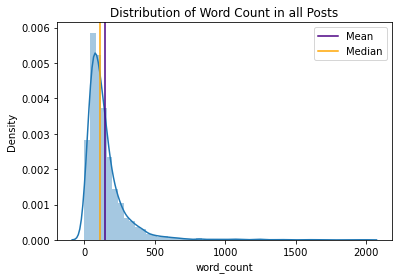

In [17]:
word_count_mean = df['word_count'].mean()
word_count_median = df['word_count'].median()
# print(word_count_mean)

sns.distplot(df['word_count'])
plt.title('Distribution of Word Count in all Posts')
plt.axvline(x=word_count_mean, color='indigo', label='Mean')
plt.axvline(x=word_count_median, color = 'orange', label='Median')
plt.legend();

Figure above: modeling distribution of word count in the entire dataset. 

In [18]:
# creating dataframes for each target category to do EDA
preg_df = df[df['beyondbump'] == 0]
btb_df = df[df['beyondbump'] == 1]

In [19]:
# examining word count of each subreddit - considering dropping short posts without any real text
preg_df.describe()

,beyondbump,word_count
count,1997.0,1997.000000
mean,0.0,145.014522
std,0.0,159.161588
min,0.0,1.000000
25%,0.0,60.000000
50%,0.0,103.000000
75%,0.0,171.000000
max,0.0,1986.000000


In [20]:
btb_df.describe()

,beyondbump,word_count
count,1780.0,1780.000000
mean,1.0,152.267416
std,0.0,137.699118
min,1.0,1.000000
25%,1.0,72.000000
50%,1.0,116.000000
75%,1.0,185.250000
max,1.0,1694.000000


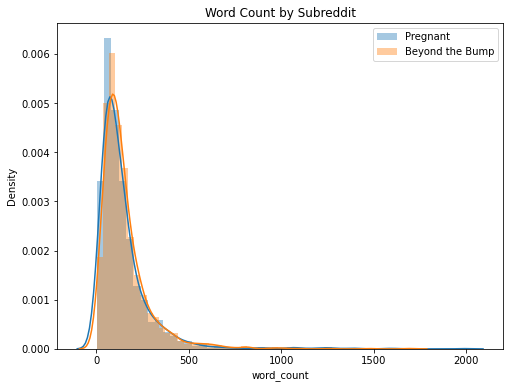

In [21]:
# examining plots together to see if there is a difference in post word count for each target
# no real difference visually

plt.figure(figsize=(8, 6))

sns.distplot(preg_df['word_count'], label='Pregnant')
sns.distplot(btb_df['word_count'], label="Beyond the Bump")
plt.title('Word Count by Subreddit')
plt.legend();

Figure above: investigating word count differentiated between the two subreddits. As can be seen, there is no easily discernable difference. 

Since we focused on Reddit data for our classification model, I chose to delete posts that had fewer than 20 words. The reason for this is because those posts are often titles with pictures or memes. For our uses, we cared more about the text-heavy posts. 

In [22]:
# deleting posts with < 20 words
df = df[df['word_count'] > 20]

## Tokenizing, Stemming, and Vectorizing

I tokenized my text here, which ultimately improved my model slightly. That said, lemmatizing did not improve my model, so I chose to remove it and try stemming instead, which improved my model slightly over using just the 'full_text' or tokenized text.

In [23]:
# tokenizing
df['tokenized_text'] = df['full_text'].apply(word_tokenize)
df['tokenized_text'] = [' '.join(text) for text in df['tokenized_text']]

In [1]:
# stemming
# used Sophie's walkthrough code here
stemmer = PorterStemmer()
df['stemmed_text'] = df.tokenized_text.apply(lambda x: ' '.join([stemmer.stem(w) for w in word_tokenize(x)]))

NameError: name 'PorterStemmer' is not defined

In [25]:
# created a custom list of stop words including 'english stop words' 
# so I wasn't including 'giveaway' words
my_stop_words = text.ENGLISH_STOP_WORDS.union(['pregnant', 'pregnancy', 'preggo', 'expecting',
                                               'baby', 'bump', 'just'])

In [26]:
# initialized a tfidf transformer
tvec = TfidfVectorizer(stop_words = my_stop_words, 
                       strip_accents = 'ascii', 
                       max_features = 500, 
                       norm = 'l2') 

# fit to the stemmed text
tvec.fit(df['full_text'])


TfidfVectorizer(max_features=500,
                stop_words=frozenset({'a', 'about', 'above', 'across', 'after',
                                      'afterwards', 'again', 'against', 'all',
                                      'almost', 'alone', 'along', 'already',
                                      'also', 'although', 'always', 'am',
                                      'among', 'amongst', 'amoungst', 'amount',
                                      'an', 'and', 'another', 'any', 'anyhow',
                                      'anyone', 'anything', 'anyway',
                                      'anywhere', ...}),
                strip_accents='ascii')

In [27]:
# create a dataframe from our vectorized text
tvec = pd.DataFrame(tvec.transform(df['full_text']).todense(), 
                       columns = tvec.get_feature_names())

### Most Common Words

In [28]:
# show 25 most common words in entire dataframe

words = []
counts = []
for col in tvec.columns: 
    words.append(col)
    counts.append(tvec[col].sum())
    
list_of_word_freq = list(zip(words, counts))
list_of_word_freq.sort(key=lambda x:x[1], reverse=True)

In [29]:
top_25 = list_of_word_freq[:25]
top_25

[('im', 238.72753633950745),
 ('like', 175.89633594386413),
 ('weeks', 155.346989498838),
 ('feel', 139.0615462326719),
 ('time', 136.58786397325542),
 ('know', 125.7651253061437),
 ('want', 111.64599580706434),
 ('day', 105.95064532731062),
 ('sleep', 104.87407866143703),
 ('did', 104.81968511783106),
 ('dont', 103.49970958649342),
 ('old', 102.42683564189721),
 ('really', 98.0077500594488),
 ('week', 95.91897591231296),
 ('going', 89.36828524547565),
 ('help', 88.97015753561172),
 ('husband', 86.59975252831796),
 ('ive', 85.77322668374822),
 ('months', 84.013468879557),
 ('days', 81.51442443199237),
 ('work', 81.170102820764),
 ('having', 78.69092727110034),
 ('little', 78.57967586966555),
 ('getting', 78.2619579966711),
 ('month', 78.06369353539266)]

In [30]:
# put the vectorized dataframe together with the original so I could analyze 
df_tvec = pd.concat([df, tvec], axis=1, join='outer')

In [31]:
preg_df = df_tvec[df_tvec['beyondbump'] == 0]
btb_df = df_tvec[df_tvec['beyondbump'] == 1]

In [32]:
# show 15 most common words in pregnant subreddit

words = []
counts = []
for col in tvec.columns: 
    words.append(col)
    counts.append(preg_df[col].sum())
    
preg_list_of_word_freq = list(zip(words, counts))
preg_list_of_word_freq.sort(key=lambda x:x[1], reverse=True)

In [33]:
preg_list_of_word_freq[:15]

[('im', 153.16509843507703),
 ('weeks', 110.58405509179104),
 ('like', 88.48565229387947),
 ('feel', 78.7112644065684),
 ('know', 69.00816393011019),
 ('time', 61.95715168789376),
 ('want', 61.47612689373563),
 ('did', 59.10637156924035),
 ('dont', 57.562018601284024),
 ('ive', 55.00634520178292),
 ('really', 52.83208230143314),
 ('week', 52.219618640863615),
 ('today', 48.8190380888312),
 ('pain', 48.66266096429578),
 ('days', 48.54097764234825)]

In [34]:
# show 15 most common words in beyondthebump subreddit

words = []
counts = []
for col in tvec.columns: 
    words.append(col)
    counts.append(btb_df[col].sum())
    
btb_list_of_word_freq = list(zip(words, counts))
btb_list_of_word_freq.sort(key=lambda x:x[1], reverse=True)

In [35]:
btb_list_of_word_freq[:15]

[('old', 77.23423984065106),
 ('like', 71.73275749185389),
 ('sleep', 69.57091163689933),
 ('im', 66.40319460831208),
 ('time', 61.93460175763019),
 ('months', 54.16832078035941),
 ('month', 52.526754389123134),
 ('feel', 49.491589308521895),
 ('day', 48.26200310652373),
 ('know', 45.385915311155955),
 ('night', 44.60643410272061),
 ('want', 42.2266328380298),
 ('help', 40.98542195139062),
 ('did', 38.3845619830761),
 ('week', 37.668916172412324)]

In [36]:
preg_bar = pd.DataFrame(preg_list_of_word_freq[:15])
btb_bar = pd.DataFrame(btb_list_of_word_freq[:15])

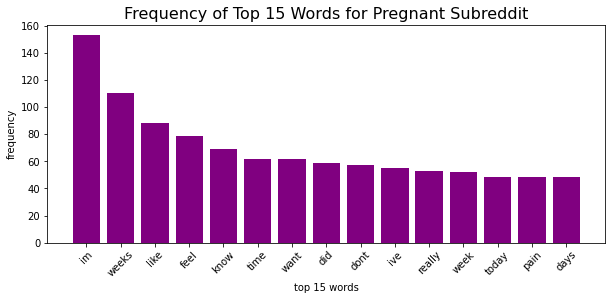

In [37]:
plt.figure(figsize=(10, 4))
plt.bar(preg_bar[0], preg_bar[1], color='purple')

plt.xticks(rotation = 45)
plt.title('Frequency of Top 15 Words for Pregnant Subreddit', size = 16)
plt.xlabel('top 15 words')
plt.ylabel('frequency'); 

Figure above: bar graph of the top 15 words in the Pregnant subreddit.

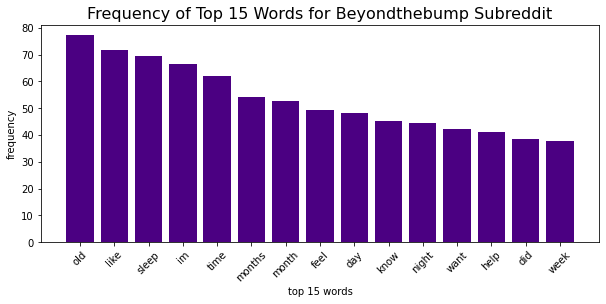

In [38]:
plt.figure(figsize=(10, 4))
plt.bar(btb_bar[0], btb_bar[1], color='indigo')

plt.xticks(rotation = 45)
plt.title('Frequency of Top 15 Words for Beyondthebump Subreddit', size = 16)
plt.xlabel('top 15 words')
plt.ylabel('frequency'); 

Figure above: bar graph of the top 15 words in the Beyondthebump subreddit.

In [39]:
# overlap in top 15 words
list(set(list(btb_bar[0])) & set(list(preg_bar[0])))

['want', 'feel', 'did', 'time', 'week', 'im', 'like', 'know']

### Bigrams

I investigated bigrams, to see if including a few of them could help my model. 

In [40]:
tvec2 = TfidfVectorizer(stop_words = my_stop_words, 
                       strip_accents = 'ascii', 
                       max_features = 500, 
                       norm = 'l2', 
                       ngram_range=(2, 2)) 
tvec2.fit(df['tokenized_text'])

TfidfVectorizer(max_features=500, ngram_range=(2, 2),
                stop_words=frozenset({'a', 'about', 'above', 'across', 'after',
                                      'afterwards', 'again', 'against', 'all',
                                      'almost', 'alone', 'along', 'already',
                                      'also', 'although', 'always', 'am',
                                      'among', 'amongst', 'amoungst', 'amount',
                                      'an', 'and', 'another', 'any', 'anyhow',
                                      'anyone', 'anything', 'anyway',
                                      'anywhere', ...}),
                strip_accents='ascii')

In [41]:
tvec2 = pd.DataFrame(tvec2.transform(df['tokenized_text']).todense(), 
                     columns = tvec2.get_feature_names())

In [42]:
df_tvec2 = pd.concat([df, tvec2], axis=1, join='outer')

In [43]:
preg_df2 = df_tvec2[df_tvec2['beyondbump'] == 0]
btb_df2 = df_tvec2[df_tvec2['beyondbump'] == 1]

In [44]:
# show 15 most common bigrams in pregnant subreddit

bigrams = []
counts = []
for col in tvec2.columns: 
    bigrams.append(col)
    counts.append(preg_df2[col].sum())
    
preg_list_of_bigram_freq = list(zip(bigrams, counts))
preg_list_of_bigram_freq.sort(key=lambda x:x[1], reverse=True)

In [45]:
preg_list_of_bigram_freq[:15]

[('feel like', 81.23599893628949),
 ('don know', 43.1825635519954),
 ('feels like', 33.101022605185214),
 ('don want', 32.4852021352867),
 ('days ago', 23.568287009019855),
 ('make sure', 22.715244625653938),
 ('gon na', 21.089244555013927),
 ('weeks days', 19.055489933927984),
 ('weeks today', 18.45434497349476),
 ('morning sickness', 17.766486360351173),
 ('weeks ago', 17.718761061306022),
 ('covid vaccine', 16.878171841409287),
 ('second trimester', 16.755628527086756),
 ('weeks ve', 16.694963408748542),
 ('couple days', 16.614964190802716)]

In [46]:
# show 15 most common bigrams in beyondthebump subreddit

bigrams = []
counts = []
for col in tvec2.columns: 
    bigrams.append(col)
    counts.append(btb_df2[col].sum())
    
btb_list_of_bigram_freq = list(zip(bigrams, counts))
btb_list_of_bigram_freq.sort(key=lambda x:x[1], reverse=True)

In [47]:
btb_list_of_bigram_freq[:15]

[('month old', 98.31092640074343),
 ('feel like', 61.46375537630405),
 ('months old', 45.432184603881346),
 ('year old', 44.626793244961476),
 ('week old', 44.235209907561256),
 ('don know', 29.04895314612495),
 ('weeks old', 26.519359486750602),
 ('don want', 24.972301526472158),
 ('ve tried', 19.25839467730892),
 ('breast milk', 18.761352761136205),
 ('car seat', 17.2206905963995),
 ('feels like', 16.16202055807777),
 ('weeks ago', 15.141358201114024),
 ('months postpartum', 12.869162301376111),
 ('lo months', 12.727578367805801)]

### Question Marks

In [48]:
# identifying how many posts contain question marks for each separate subreddit
btb_0 = df['beyondbump'] == 0
has_questions = df['full_text'].str.contains('\?')

df[(btb_0) & (has_questions)].shape


(1418, 5)

In [49]:
df[df['beyondbump'] == 1].shape # 82% contain question marks

(1735, 5)

In [50]:
# I'm going to create a column for the number of question marks
# since there is such a difference in percentage that includes question marks

btb_1 = df['beyondbump'] == 1
has_questions = df['full_text'].str.contains('\?')

df[(btb_1) & (has_questions)].shape


(1368, 5)

In [51]:
df[df['beyondbump'] == 0].shape # 69%

(1914, 5)

In [52]:
df['question_mark'] = (df['full_text'].str.contains('\?')).astype(int)

### Bigram Columns

In [53]:
# create a column for whether it says 'weeks old' or 'month(s) old' 
# since those were popular bigrams for the beyondbump subreddit

searchfor = ['weeks old', 'month old', 'months old']
df['something_old'] = (df['tokenized_text'].str.contains('|'.join(searchfor))).astype(int)


### Exporting Data to CSV

In [54]:
df.to_csv('../data/clean_df.csv', index=False)